In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_wine
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from tqdm import trange
from utils import evaluate_clustering, get_clusters, plot_training_history, plot_3d_clustering_comparison

# GraphEncoder
From the paper: [Learning Deep Representations for Graph Clustering](https://cdn.aaai.org/ojs/8916/8916-13-12444-1-2-20201228.pdf)

## Loading the data
We use the wine dataset such as used in the paper.

In [12]:
dataset = load_wine()
X, Y = MinMaxScaler().fit_transform(dataset['data']), dataset['target']
X.shape, Y.shape

((178, 13), (178,))

## Preprocessing the data
The paper uses cosine similarity as the similarity measure between nodes. We will use the same.

In [13]:
S = cosine_similarity(X, X)
D = np.diag(1.0 / np.sqrt(S.sum(axis=1)))
X_train = torch.tensor(D @ S).float()
X_train[:5, :5]

tensor([[0.0813, 0.0791, 0.0781, 0.0785, 0.0763],
        [0.0805, 0.0827, 0.0776, 0.0793, 0.0748],
        [0.0772, 0.0754, 0.0803, 0.0771, 0.0768],
        [0.0794, 0.0788, 0.0789, 0.0822, 0.0751],
        [0.0743, 0.0716, 0.0757, 0.0723, 0.0791]])

## GraphEncoder Model
The model is a simple Autoencoder with three fully connected layers in the encoder and same in the decoder. 

In [14]:
class GraphEncoder(nn.Module):
	def __init__(self, in_channels: int, latent_dim: int):
		super(GraphEncoder, self).__init__()
		self.encoder = nn.Sequential(
		nn.Linear(in_channels, 4 * latent_dim),
		nn.ReLU(),
		nn.Linear(4 * latent_dim, 2 * latent_dim),
		nn.ReLU(),
		nn.Linear(2 * latent_dim, latent_dim),
		)
		self.decoder = nn.Sequential(
		nn.Linear(latent_dim, 2 * latent_dim),
		nn.ReLU(),
		nn.Linear(2 * latent_dim, 4 * latent_dim),
		nn.ReLU(),
		nn.Linear(4 * latent_dim, in_channels),
		)
	
	def encode(self, x: torch.tensor) -> torch.tensor:
		return self.encoder(x)

	def decode(self, z: torch.tensor) -> torch.tensor:
		return self.decoder(z)
		
	def forward(self, x: torch.tensor) -> torch.tensor:
		z = self.encode(x)
		return self.decode(z), z
		
	def loss(self, x_hat: torch.tensor, x: torch.tensor) -> torch.tensor:
		return F.mse_loss(x_hat, x)

## Training the model
The model is trained to reconstruct the graph by minimizing the MSELoss between the original and reconstructed graph.

In [15]:
def train(model: nn.Module, optimizer: optim.Optimizer, x: torch.tensor) -> float:
	optimizer.zero_grad()
	x_hat, _ = model(x)
	loss = model.loss(x_hat, x)
	loss.backward()
	optimizer.step()
	return loss.item()

In [16]:
latent_dim, num_epochs, lr, n_clusters = 16, 100, .01, len(np.unique(Y))
model = GraphEncoder(len(X_train[0]), latent_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [17]:
metrics = np.zeros((num_epochs, 5))
for epoch in (pbar := trange(num_epochs, desc="Epochs")):
	loss = train(model, optimizer, X_train)
	z = model.encode(X_train).detach().numpy()
	accuracy, nmi, ari, silouhette = evaluate_clustering(z, Y, get_clusters(z, n_clusters))
	metrics[epoch] = np.array([loss, accuracy, nmi, ari, silouhette])
	pbar.set_postfix({"Loss": loss, "Accuracy": accuracy, "NMI": nmi, "ARI": ari, "Silouhette": silouhette})

Epochs: 100%|██████████| 100/100 [00:01<00:00, 51.91it/s, Loss=5.13e-5, Accuracy=0.674, NMI=0.556, ARI=0.405, Silouhette=0.669]


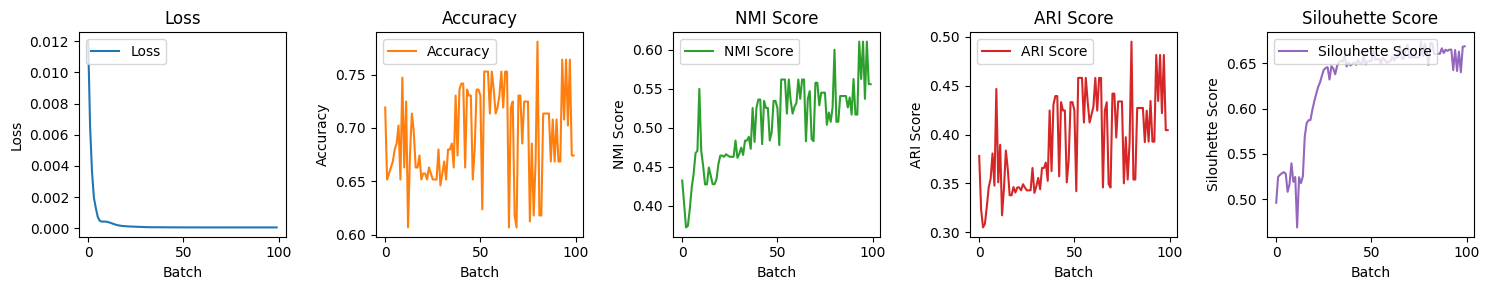

In [18]:
plot_training_history(['Loss', 'Accuracy', 'NMI Score', 'ARI Score', 'Silouhette Score'], metrics, "Training loss and clustering metrics evolution")

## Evaluating the model
We evaluate the model by clustering the latent space using KMeans and comparing the clustering with the true labels.

In [19]:
z = model.encode(X_train).detach().numpy()
cluster_labels = get_clusters(z, n_clusters)
true_labels = Y

accuracy, nmi, ari, silouhette = evaluate_clustering(z, true_labels, cluster_labels)
print(f"Accuracy: {accuracy}, NMI: {nmi}, ARI: {ari}, Silouhette score: {silouhette}")

Accuracy: 0.7078651685393258, NMI: 0.5625195631298123, ARI: 0.43440884388687817, Silouhette score: 0.6646144986152649


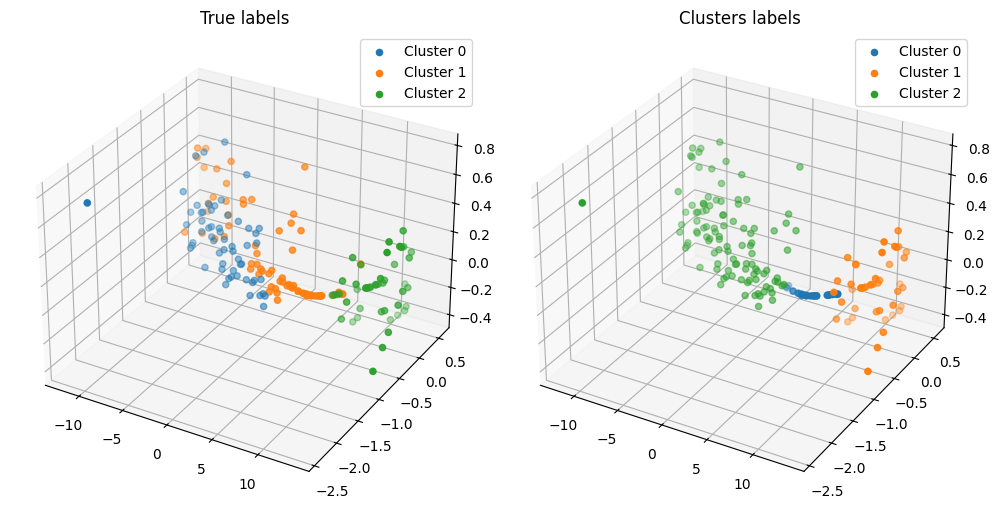

In [20]:
plot_3d_clustering_comparison(z, true_labels, cluster_labels, n_clusters)